In [1]:
import torch
import random
from transformers import TrOCRProcessor


batch_size=4

processor = TrOCRProcessor.from_pretrained(
    'processor/microsoft/trocr-base-handwritten')

processor

TrOCRProcessor:
- image_processor: ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "TrOCRProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: RobertaTokenizerFast(name_or_path='processor/microsoft/trocr-base-handwritten', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_w

In [2]:
#准备数据
#接下来我们要喂给模型以及裁剪好的，同时又修剪填充至统一大小的图片
from datasets import load_from_disk, Dataset

def f():
    dataset = load_from_disk('dataset/data')['train']
    for data in dataset:
        for box in data['ocr']:
            image = data['image'].crop(box['box'])
            yield {'image': image, 'text': box['word']}


dataset = Dataset.from_generator(f)

dataset, dataset[0]

(Dataset({
     features: ['image', 'text'],
     num_rows: 68000
 }),
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=34x26>,
  'text': '竺航欣'})

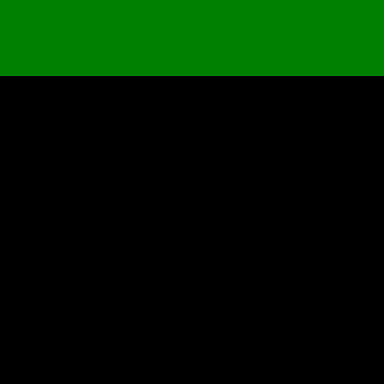

In [10]:
import PIL.Image

#填充图片至统一大小384*384
def pad(image):
    w, h = image.size

    ratio = 384 / max(w, h)

    w = int(ratio * w)
    h = int(ratio * h)

    image = image.resize([w, h])

    #新建一个全黑的画布
    pad = PIL.Image.new('RGB', [384, 384], 'black')
    #在（0，0）处黏贴图片
    pad.paste(image, [0, 0])

    return pad

#效果展示
pad(PIL.Image.new('RGB', [100, 20], 'green'))

In [11]:
#这部分与定位部分的代码同理，不再赘述
def f(data):
    image = [i['image'] for i in data]
    text = [i['text'] for i in data]

    image = [pad(i) for i in image]
    pixel_values = processor(image,
                             return_tensors='pt').pixel_values.to('cuda')

    input_ids = processor.tokenizer(text,
                                    truncation=True,
                                    padding='max_length',
                                    max_length=128,
                                    return_tensors='pt').input_ids.to('cuda')

    return pixel_values, input_ids


loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     drop_last=True,
                                     collate_fn=f)

len(loader), next(iter(loader))

(17000,
 (tensor([[[[ 0.8275,  0.8275,  0.8275,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.8275,  0.8275,  0.8275,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.8275,  0.8275,  0.8275,  ..., -1.0000, -1.0000, -1.0000],
            ...,
            [ 0.8431,  0.8431,  0.8431,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.8431,  0.8431,  0.8431,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.8431,  0.8431,  0.8431,  ..., -1.0000, -1.0000, -1.0000]],
  
           [[ 0.9373,  0.9373,  0.9373,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.9373,  0.9373,  0.9373,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.9373,  0.9373,  0.9373,  ..., -1.0000, -1.0000, -1.0000],
            ...,
            [ 0.8980,  0.8980,  0.8980,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.8980,  0.8980,  0.8980,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.8980,  0.8980,  0.8980,  ..., -1.0000, -1.0000, -1.0000]],
  
           [[ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000

In [12]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        from transformers import VisionEncoderDecoderConfig, ViTModel, TrOCRForCausalLM

        config = VisionEncoderDecoderConfig.from_pretrained(
            'model/microsoft/trocr-base-stage1')
        
        #config.use_pretrained_backbone = False

        self.encoder = ViTModel(config.encoder)
        self.decoder = TrOCRForCausalLM(config.decoder)

        from transformers import VisionEncoderDecoderModel
        parameters = VisionEncoderDecoderModel.from_pretrained(
            'model/microsoft/trocr-base-stage1')
        self.encoder.load_state_dict(parameters.encoder.state_dict())
        self.decoder.load_state_dict(parameters.decoder.state_dict())
        del parameters

        self.train()
        self.to('cuda')

    def forward(self, pixel_values, input_ids):
        last_hidden_state = self.encoder(pixel_values).last_hidden_state

        input_ids_shifted = torch.zeros_like(input_ids)
        input_ids_shifted[:, 1:] = input_ids[:, :-1].clone()
        input_ids_shifted[:, 0] = processor.tokenizer.cls_token_id

        return self.decoder(input_ids=input_ids_shifted,
                            encoder_hidden_states=last_hidden_state).logits


model = Model()

with torch.no_grad():
    print(model(*next(iter(loader))))

C:\Users\76758\anaconda3\envs\pytorch\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at model/microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[[-13.0080, -13.0373,  12.0408,  ..., -12.6863, -12.9229, -11.5388],
         [-14.1095, -13.4633,  11.1647,  ..., -13.7185, -13.3112, -12.5025],
         [-14.3663, -13.9464,  13.2962,  ..., -13.5188, -13.7461, -13.5494],
         ...,
         [-11.2676, -11.3228,  11.4693,  ..., -11.5510, -11.7379, -10.9230],
         [-11.9383, -10.8586,  12.1512,  ..., -11.8008, -11.7588, -11.3165],
         [-11.5888, -10.6852,  12.1466,  ..., -12.0939, -11.5667, -11.1521]],

        [[-11.2469, -11.3462,  12.4658,  ..., -10.0075, -10.9729, -10.9649],
         [-11.6418, -11.2958,  11.0686,  ..., -10.2152, -11.1086, -11.0561],
         [-12.4888, -11.9394,  13.5417,  ..., -11.4685, -13.0003, -12.6705],
         ...,
         [ -9.5082,  -9.5631,  10.0556,  ...,  -8.6511,  -9.4429,  -8.8269],
         [ -9.4227,  -9.9553,  10.4200,  ...,  -9.3621,  -9.3669,  -8.8485],
         [ -9.9863,  -9.6293,  10.4471,  ...,  -8.7183,  -9.2198,  -8.7553]],

        [[-11.9671, -10.3093,   8.2175,  ...

In [13]:
#这是我自己写的用opencv查看图片的代码
'''
def show(image):
    import cv2
    import numpy as np

    #图片还原
    image = image - image.min()
    image = image / image.max() * 255
    image = image.permute(1, 2, 0)
    image = np.uint8(image.to('cpu').numpy())


    image=cv2.cvtColor(image, cv2.COLOR_RGB2BGR)



    cv2.imshow("image",image)
    
    
    cv2.waitKey()
    cv2.destroyAllWindows()

    
    

show(torch.randn(3, 100, 100))
'''
#这是导写的代码
import numpy as np
import PIL.Image
from matplotlib import pyplot as plt


def show(image):
    image = image - image.min()
    image = image / image.max() * 255
    image = image.permute(1, 2, 0)
    image = np.uint8(image.to('cpu').numpy())
    image = PIL.Image.fromarray(image, 'RGB')

    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(image)
    plt.show()


show(torch.randn(3, 100, 100))

In [14]:
def decode(input_ids):
    input_ids = input_ids.to('cpu').tolist()

    if processor.tokenizer.sep_token_id in input_ids:
        idx = input_ids.index(processor.tokenizer.sep_token_id) + 1
        input_ids = input_ids[:idx]

    return processor.tokenizer.decode(input_ids)


decode(torch.LongTensor([0, 19751, 12590, 2534, 13, 2, 1, 1]))

'<s>Insurance Institute for</s>'

In [15]:
#训练模型
#我只训练了一个epoch就停止了，希望有更好装备的同学继续训练，如果可以的话，在评论区分享一下完整训练后的模型，谢谢了
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss(
    ignore_index=processor.tokenizer.pad_token_id)

for epoch in range(15):
    for i, (pixel_values, input_ids) in enumerate(loader):
        logits = model(pixel_values, input_ids)

        loss = criterion(logits.flatten(0, 1), input_ids.flatten())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        if i % 4000 == 0:
            print(epoch, i, loss.item())
            testi = random.randint(0, batch_size-1)
            ###由于环境问题注释掉了
            #show(pixel_values[testi])
            print(decode(input_ids[testi]))
            print(decode(logits[testi].argmax(1)))




0 0 10.870011329650879
<s>27</s>
</s>
0 4000 0.7680874466896057
<s>937589197712198101</s>
<s><s>758919771219801</s>
0 8000 1.3053677082061768
<s>黑龙江省双鸭山市友谊县</s>
<s><s>��龙江省叉鸿帱�市</s>


KeyboardInterrupt: 

In [16]:
torch.save(model.to('cpu'), 'model/文字识别.model')